In [6]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd  /content/drive/'My Drive'/'CV Project'/
!pwd
!ls /scratch/ap6624/CV/casia2groundtruth/CASIA2.0_revised/

/home/ap6624/CV
Au  Tp	au_list.txt  tp_list.txt


In [ ]:
# !pip install sklearn

In [7]:
import os
import datetime
import numpy as np
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image, ImageChops, ImageEnhance, ImageFilter
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau, ModelCheckpoint
from tqdm import tqdm

In [ ]:
def get_ela(dir, filename):
    path = os.path.join(dir, filename)
    temp_img = 'tmp_img_bw.jpg'

    image = Image.open(path)
    filtered_image = image.convert('RGB').filter(ImageFilter.BoxBlur(0.5))
    filtered_image.save(temp_img, 'JPEG', quality = 90)
    
    temp_image = Image.open(temp_img)
    
    ela_image = ImageChops.difference(filtered_image, temp_image)
    
    extremas = ela_image.getextrema()
    max_ext = max([x[1] for x in extremas])
    if max_ext == 0:
        scale = 255.0
    else:
        scale = 255.0 / max_ext
    
    ela_image = ImageEnhance.Brightness(ela_image)
    ela_image = ela_image.enhance(scale)

    result = np.array(ela_image.resize((128,128))).flatten()/255

    return result

In [10]:
authentic_path = '/scratch/ap6624/CV/casia2groundtruth/CASIA2.0_revised/Au'
tampered_path = '/scratch/ap6624/CV/casia2groundtruth/CASIA2.0_revised/Tp'

X_arr = []
y_arr = []

for dir, _, files in os.walk(authentic_path):
    for filename in tqdm(files):
        if filename.endswith('jpg') or filename.endswith('png'):
            X_arr.append(get_ela(dir, filename))
            y_arr.append(0)

num_authentic = len(X_arr)
print("Authentic Images:", num_authentic)

for dir, _, files in os.walk(tampered_path):
    for filename in tqdm(files):
        if filename.endswith('jpg') or filename.endswith('png'):
            X_arr.append(get_ela(dir, filename))
            y_arr.append(1)
            
print("Tampered Images:", len(X_arr) - num_authentic)

X = np.array(X_arr)
# X = X_arr
y = y_arr

print("Shape of Train Data")
print(X.shape)

100%|██████████| 7492/7492 [02:01<00:00, 61.87it/s]


Authentic Images:
Train Size: 7437


100%|██████████| 5123/5123 [01:10<00:00, 72.16it/s] 


Tampered Images:
Train+Fake Size: 9501
Shape of Train Data
(9501, 49152)


In [11]:
print(X.shape)

y = to_categorical(y, 2)
X = X.reshape(-1, 128, 128, 3)
print(X.shape)

(9501, 49152)
(9501, 128, 128, 3)


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(7600, 128, 128, 3) (7600, 2)
(1901, 128, 128, 3) (1901, 2)


In [ ]:
# X_save_path = 'ELA_extracted_X.npy'
# y_save_path = 'ELA_extracted_y.npy'
# with open(X_save_path, 'wb') as f1:
#     np.save(f1, X)
# with open(y_save_path, 'wb') as f2:
#     np.save(f2, y)

##Using a Basic CNN

In [15]:
basicCNNModel = Sequential()
basicCNNModel.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'valid',activation = 'relu',input_shape = (128,128,3)))
basicCNNModel.add(MaxPool2D(pool_size = (2,2)))
basicCNNModel.add(Dropout(0.1))

basicCNNModel.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'valid',activation = 'relu'))
basicCNNModel.add(MaxPool2D(pool_size = (2,2)))
basicCNNModel.add(Dropout(0.1))

basicCNNModel.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'valid',activation = 'relu'))
basicCNNModel.add(MaxPool2D(pool_size = (2,2)))
basicCNNModel.add(Dropout(0.2))

basicCNNModel.add(Flatten())
basicCNNModel.add(Dense(256, activation = 'relu'))
basicCNNModel.add(Dropout(0.3))
basicCNNModel.add(Dense(2, activation = 'softmax'))


basicCNNModel.summary()

2021-12-15 19:18:25.415095: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-12-15 19:18:25.416462: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-12-15 19:18:26.013289: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:d8:00.0 name: NVIDIA Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2021-12-15 19:18:26.013363: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-12-15 19:18:26.341275: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2021-12-15 19:18:26.341385: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 124, 124, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 58, 58, 32)        25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 29, 29, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 29, 29, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 32)        2

In [16]:
checkpoint_filepath = 'BasicCNN_Detection_Blur/checkpoint'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

epochs = 8
batch_size = 32
opt = Adam(learning_rate = 0.001)

early_stopping = EarlyStopping(monitor = 'val_accuracy',patience = 2, mode = 'auto', min_delta = 0)

basicCNNModel.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])

In [18]:
epochs = 8
batch_size = 32

basicCNNModel.fit(X_train,y_train,batch_size = batch_size,epochs = epochs,validation_data = (X_test, y_test),callbacks = [early_stopping, model_checkpoint_callback])

2021-12-15 19:20:48.596334: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-12-15 19:20:48.609519: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2900000000 Hz


Epoch 1/8
238/238 [==============================] - 544s 2s/step - loss: 0.4847 - accuracy: 0.7775 - val_loss: 0.4113 - val_accuracy: 0.7354
Epoch 2/8
238/238 [==============================] - 538s 2s/step - loss: 0.4372 - accuracy: 0.7837 - val_loss: 0.4069 - val_accuracy: 0.7181
Epoch 3/8
238/238 [==============================] - 540s 2s/step - loss: 0.4187 - accuracy: 0.7797 - val_loss: 0.3918 - val_accuracy: 0.7253
Epoch 4/8
238/238 [==============================] - 544s 2s/step - loss: 0.4949 - accuracy: 0.7775 - val_loss: 0.4212 - val_accuracy: 0.7406
Epoch 5/8
238/238 [==============================] - 538s 2s/step - loss: 0.4671 - accuracy: 0.7731 - val_loss: 0.4013 - val_accuracy: 0.7751
Epoch 6/8
238/238 [==============================] - 540s 2s/step - loss: 0.4284 - accuracy: 0.7869 - val_loss: 0.3847 - val_accuracy: 0.7954
Epoch 7/8
238/238 [==============================] - 544s 2s/step - loss: 0.4143 - accuracy: 0.8071 - val_loss: 0.3919 - val_accuracy: 0.7852
Epoch 

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)


    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

           0       0.80      1.00      0.89      1493
           1       1.00      0.06      0.11       408

    accuracy                           0.80      1901
   macro avg       0.90      0.53      0.50      1901
weighted avg       0.84      0.80      0.72      1901



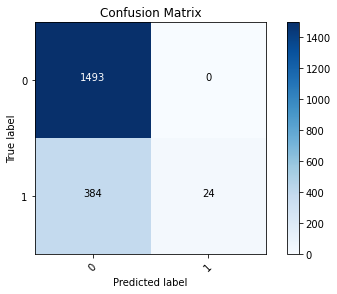

In [31]:
Y_pred = basicCNNModel.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(y_test,axis = 1) 

cfm = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix(cfm, classes = range(2))

from sklearn.metrics import classification_report

print(classification_report(Y_true, Y_pred_classes))